In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%M-%d')

In [38]:
#read data
catfish_sales = pd.read_csv('time_series_od.csv', parse_dates=[1], index_col=0, date_parser=parser, sep= ',')
catfish_sales.set_index('Date', inplace= True)
catfish_sales = catfish_sales.squeeze()
catfish_sales.head()

C:\Users\chaos\AppData\Local\Temp\ipykernel_27332\669281080.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('time_series_od.csv', parse_dates=[1], index_col=0, date_parser=parser, sep= ',')


Date
2012-01-31 00:01:00    51.637723
2012-01-29 00:02:00    51.632639
2012-01-31 00:03:00    50.823663
2012-01-30 00:04:00    49.123303
2012-01-31 00:05:00    49.737167
Name: value, dtype: float64

In [39]:
#infer the frequency of the data
catfish_sales = catfish_sales.sort_index(ascending= True).asfreq(pd.infer_freq(catfish_sales.index), method= 'ffill')

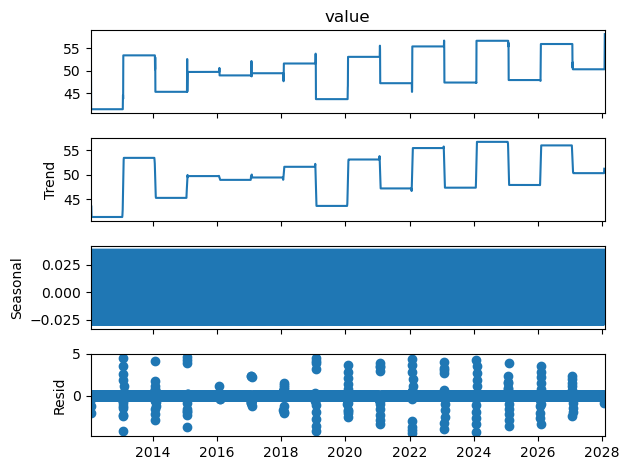

In [40]:
# seasonal decomposition of plot 
nresult = seasonal_decompose(catfish_sales, model='additive', period=12)
nresult.plot()
plt.show()

In [50]:
# take a smaller sample
start_date = datetime(2012,1,31)
end_date = datetime(2024,12,31)
lim_catfish_sales = catfish_sales[start_date:end_date]

Introduce an Anomaly

In [55]:
#At December 1 1998
lim_catfish_sales[datetime(2016,8,13)] = 150

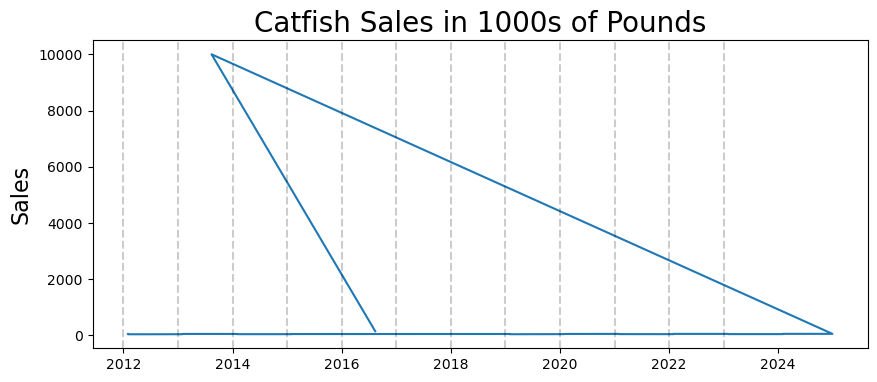

In [56]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [57]:
first_diff = lim_catfish_sales.diff()[1:]

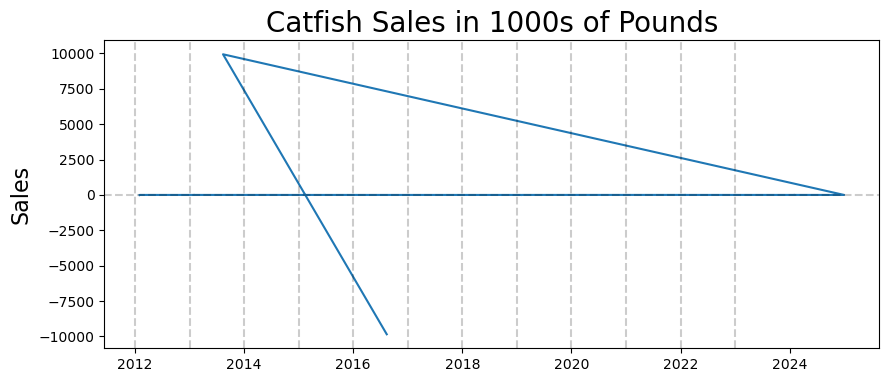

In [58]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# Get training and testing sets

In [14]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# Make Predictions

In [15]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)

In [16]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

c:\Users\chaos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\chaos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\chaos\AppData\Local\Temp\ipykernel_18496\3978322752.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25744.66423405]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = pred
c:\Users\chaos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parame

In [17]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

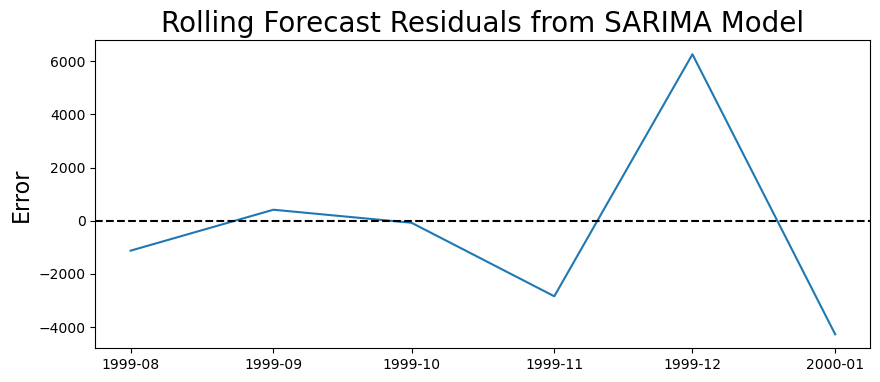

In [18]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

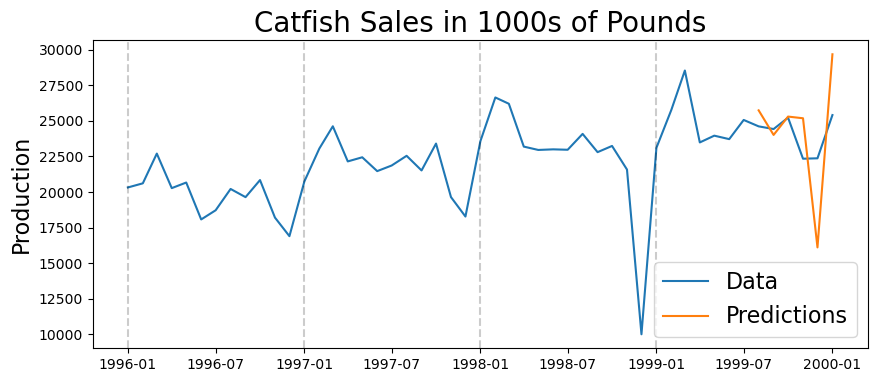

In [19]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.1069


In [21]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 3342.7881482761845


# Detecting the Anomaly

## Attempt 1: Deviation Method

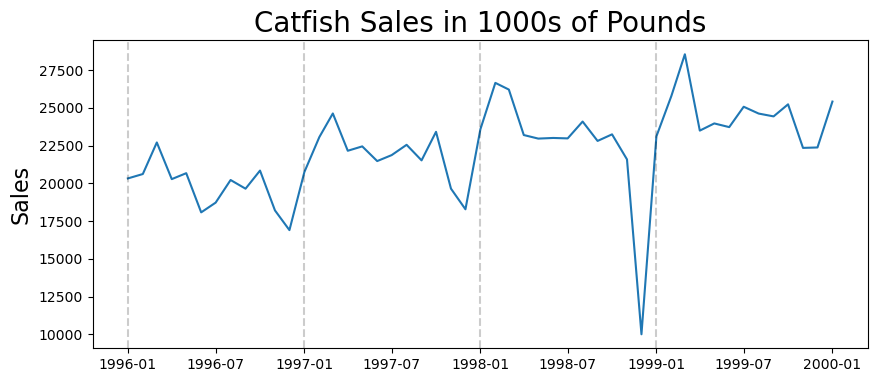

In [22]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [23]:
rolling_deviations = pd.Series(dtype=float, index = lim_catfish_sales.index)

In [24]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = lim_catfish_sales.loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

In [25]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

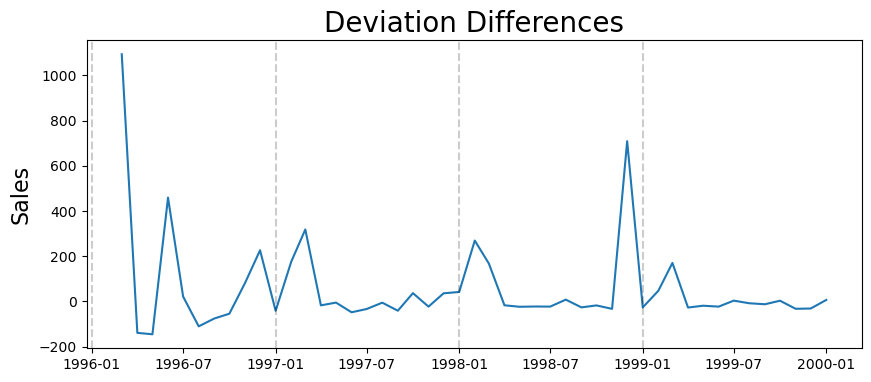

In [26]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Attempt 2: Seasonal Method

In [27]:
month_deviations = lim_catfish_sales.groupby(lambda d: d.month).std()

Text(0, 0.5, 'Sales')

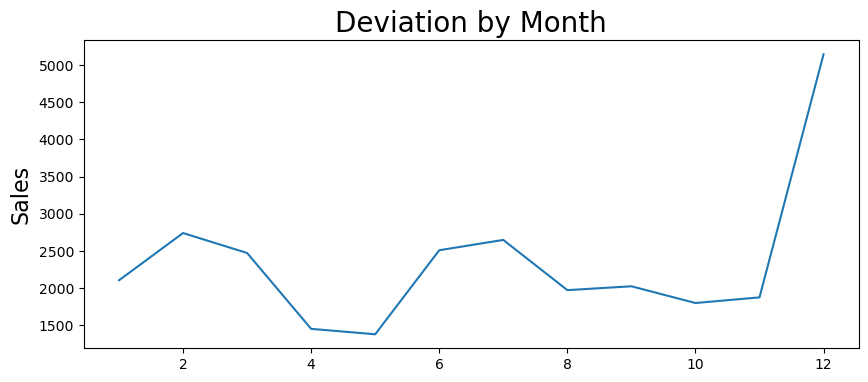

In [28]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

## So, the anomaly occurs in a December

In [29]:
december_data = lim_catfish_sales[lim_catfish_sales.index.month == 12]

In [30]:
december_data

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    10000
1999-12-01    22372
Name: Total, dtype: int64

In [31]:
min_dev = 9999999
curr_anomaly = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [32]:
curr_anomaly

Timestamp('1998-12-01 00:00:00')

# What to do about the anomaly?

## Simple Idea: use mean of other months

In [33]:
adjusted_data = lim_catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

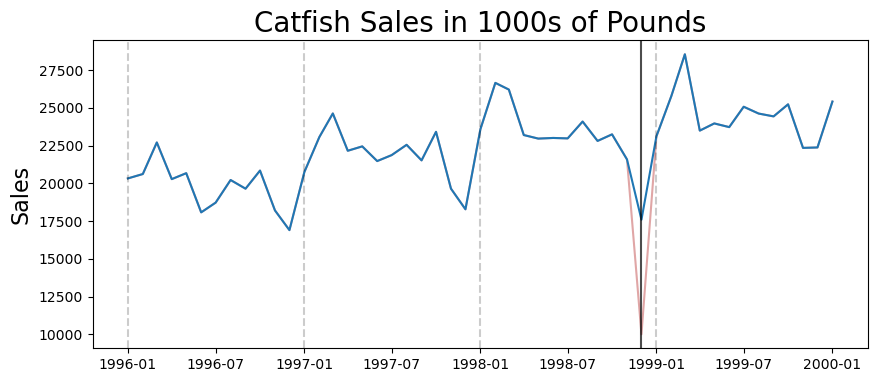

In [34]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

# Resulting Predictions

In [35]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [36]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

c:\Users\chaos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\chaos\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\chaos\AppData\Local\Temp\ipykernel_18496\412036786.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25821.98213947]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = pred
c:\Users\chaos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('No

In [37]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

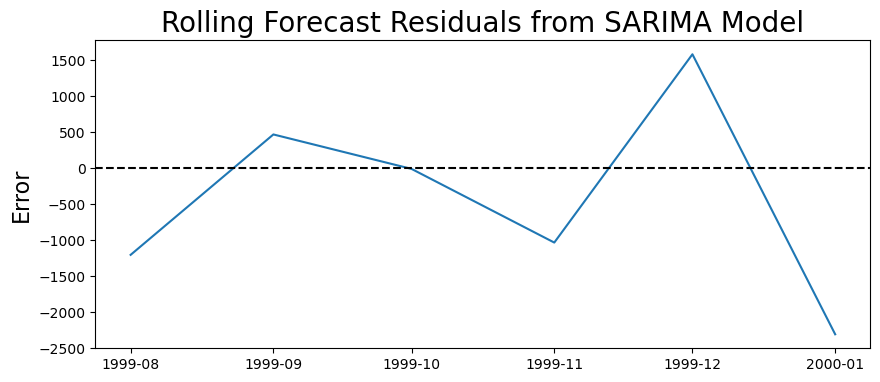

In [38]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

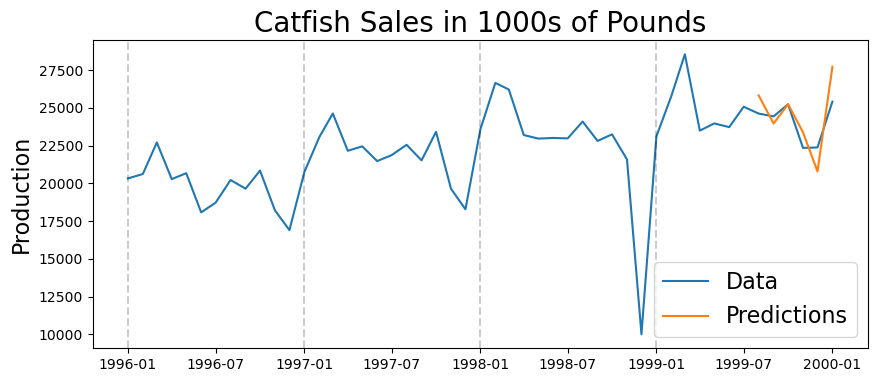

In [39]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [40]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0461


In [41]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1328.3163347003278


In [38]:
# https://www.youtube.com/watch?v=0wfOOl5XtcU

C:\Users\chaos\AppData\Local\Temp\ipykernel_18496\844818456.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  times = pd.date_range('2012-01-01', periods=200, freq='M')


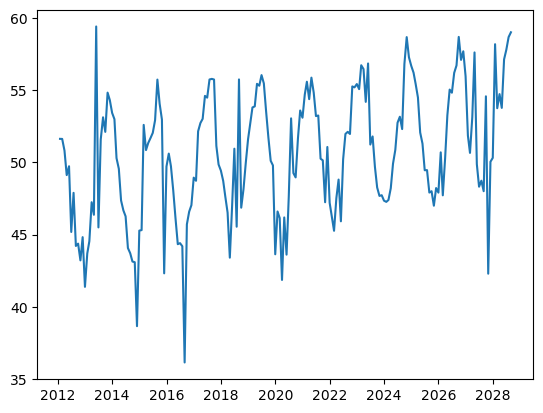

In [42]:
#Here we will just create a random series with seasonality and a slight trend
seasonality = ((np.cos(np.arange(1, 201)*6)*5 + 50))
np.random.seed(1)
trend = np.linspace(-2,3,200)
standard_noise = np.random.normal(0, 1, 200)
true = np.random.choice([0, 1], size = 200, p=[0.85, 0.15])
noise = np.random.normal(0, 5, 200)
y = seasonality + true*noise + trend + standard_noise


times = pd.date_range('2012-01-01', periods=200, freq='M')
df = pd.DataFrame({'value': y}, index = times)


plt.plot(times, y)
plt.show()

In [ ]:
# take a smaller sample
start_date = datetime(2012,1,1)
end_date = datetime(2028,1,1)

my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
train_data = df[:-20].copy()

train_end = datetime(2022,1,1)
test_end = datetime(2024,1,1)

rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = train_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred


LinAlgError: Schur decomposition solver error.

In [117]:
rolling_residuals = test_data - rolling_predictions
print(rolling_residuals)

            2022-01-31 00:00:00  2022-02-28 00:00:00  2022-03-31 00:00:00  \
2022-01-31                  NaN                  NaN                  NaN   
2022-02-28                  NaN                  NaN                  NaN   
2022-03-31                  NaN                  NaN                  NaN   
2022-04-30                  NaN                  NaN                  NaN   
2022-05-31                  NaN                  NaN                  NaN   
2022-06-30                  NaN                  NaN                  NaN   
2022-07-31                  NaN                  NaN                  NaN   
2022-08-31                  NaN                  NaN                  NaN   
2022-09-30                  NaN                  NaN                  NaN   
2022-10-31                  NaN                  NaN                  NaN   
2022-11-30                  NaN                  NaN                  NaN   
2022-12-31                  NaN                  NaN                  NaN   

In [111]:
flatten_df = pd.DataFrame(new_dict).to_numpy().flatten()
# flatten_df
value = []
for index in range(len(rolling_predictions)):
    value.append(pd.DataFrame(new_dict[index]).stack().values[1])
rolling_predictions = pd.DataFrame({'value':value}, index = test_data.index)

In [116]:
rolling_predictions

,value,2022-01-31 00:00:00,2022-02-28 00:00:00,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,...,2023-03-31 00:00:00,2023-04-30 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00,2023-08-31 00:00:00,2023-09-30 00:00:00,2023-10-31 00:00:00,2023-11-30 00:00:00,2023-12-31 00:00:00
2022-01-31,46.202248,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008,...,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008,47.265008
2022-02-28,45.265238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,47.525972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-30,48.814543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-31,45.922681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,50.215706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-31,51.978229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-31,52.124568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,51.975821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,55.270914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


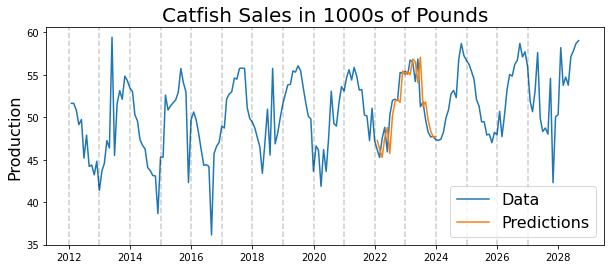

In [113]:

plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [60]:
test_data

,value
2022-01-31,46.202248
2022-02-28,45.265238
2022-03-31,47.525972
2022-04-30,48.814543
2022-05-31,45.922681
2022-06-30,50.215706
2022-07-31,51.978229
2022-08-31,52.124568
2022-09-30,51.975821
2022-10-31,55.270914


In [46]:
df.to_csv('time_series_od')